# Descripcion del proyecto - Test A/B

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

1. Comenzamos con la importación de las librerias y los datos

In [87]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objects as go
from scipy.stats import levene, mannwhitneyu, shapiro
from statsmodels.stats.proportion import proportions_ztest

In [51]:
ab_project = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
ab_new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events_upd = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
ab_participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

1. Revisión de los datasets

In [52]:
# El calendario de eventos de marketing para 2020
print(ab_project.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


In [53]:
ab_project.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [54]:
#Todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
print(ab_new_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


In [55]:
ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [56]:
#Todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
print(events_upd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


In [57]:
events_upd.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [58]:
#Tabla con los datos de los participantes de la prueba
print(ab_participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


In [59]:
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


1. Cambiaremos los tipos de datos de las columnas 'date' en todos los datasets

In [60]:
ab_project['start_dt'] = pd.to_datetime(ab_project['start_dt'], format='%Y-%m-%d')
ab_project['finish_dt'] = pd.to_datetime(ab_project['finish_dt'], format='%Y-%m-%d')

ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'], format='%Y-%m-%d')

events_upd['event_dt'] = pd.to_datetime(events_upd['event_dt'], format='%Y-%m-%d')

2. Verificamos todos los valores nulos en cada uno de los datasets y sus valores duplicados

In [61]:
print(ab_project.isnull().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [62]:
print(ab_project.duplicated().sum())

0


In [63]:
print(ab_new_users.isnull().sum())

user_id       0
first_date    0
region        0
device        0
dtype: int64


In [64]:
print(ab_new_users.duplicated().sum())

0


In [65]:
print(events_upd.isnull().sum())

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


In [66]:
print(events_upd.duplicated().sum())

0


In [67]:
#Rellenaremos los datos ausentes con 0.0 ya que son los datos de Login los cuales no requiere gastos
events_upd['details'] = events_upd['details'].fillna(0.0)

In [68]:
print(ab_participants.isnull().sum())

user_id    0
group      0
ab_test    0
dtype: int64


In [69]:
print(ab_participants.duplicated().sum())

0


2. Verificamos los datos de los eventos.

In [70]:
#Nombre de los eventos únidos:
events_upd['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [71]:
#Cantidad de eventos por nombre de evento:
events_upd['event_name'].value_counts()

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

In [72]:
#Calcularemos las fechas mínimas y máximas que cubren los datos de eventos
min_date = events_upd['event_dt'].min()
max_date = events_upd['event_dt'].max()

print(f"Fecha mínima: {min_date}")
print(f"Fecha máxima: {max_date}")

Fecha mínima: 2020-12-07 00:00:33
Fecha máxima: 2020-12-30 23:36:33


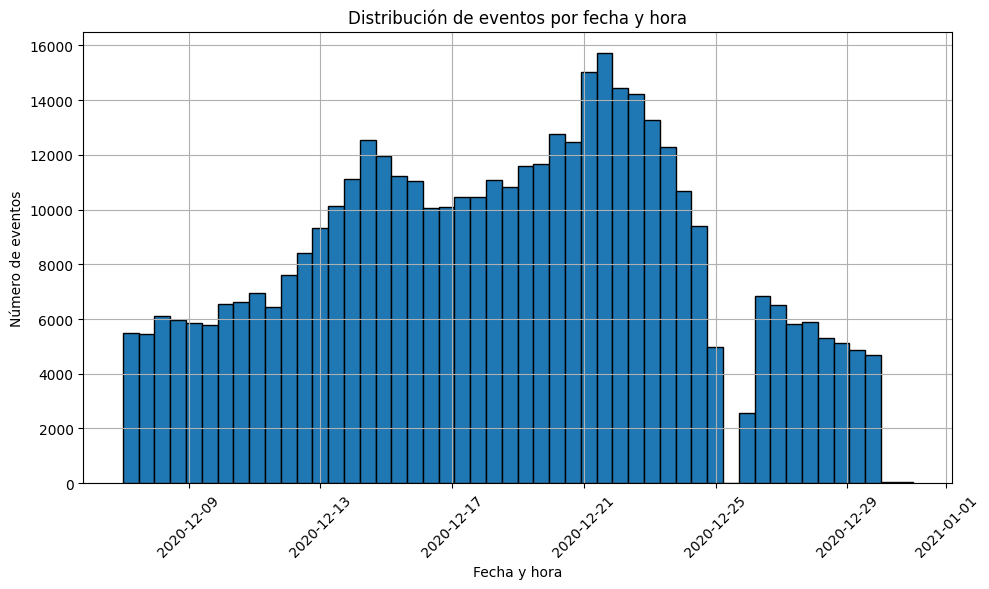

In [73]:
#Graficamos un histograma de distribución de eventos por fecha y hora
plt.figure(figsize=(10, 6))
events_upd['event_dt'].hist(bins=50, edgecolor='black')
plt.title('Distribución de eventos por fecha y hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

El Histograma nnos muestra que los eventos comenzaron en 2020-12-07 y fueron incrementando con un pico de mas de 1500 eventos el 2020-12-21, luego fueron disminuyendo hasta el 2020-12-30.

In [74]:
#Ahora revisaremos la cantidad de usuarios por grupo de prueba
ab_participants['group'].value_counts()

A    8214
B    6311
Name: group, dtype: int64

In [75]:
#Nos aseguramos que un user_id pertenezca a un solo grupo
user_id_groups = ab_participants.groupby('user_id')['group'].nunique()
user_id_groups.head()

user_id
0002CE61FF2C4011    1
001064FEAAB631A1    1
0010A1C096941592    1
001E72F50D1C48FA    1
002412F1EB3F6E38    1
Name: group, dtype: int64

In [76]:
multiple_group_users = user_id_groups[user_id_groups > 1]
print(multiple_group_users)

user_id
0082295A41A867B5    2
00E68F103C66C1F7    2
02313B9E82255F47    2
04F2CF340B4F3822    2
051D59BC38C3B3AA    2
                   ..
FE2AF0E94DBD470E    2
FE8F9858BBE502D9    2
FEA0C585A53E7027    2
FEC0BCA6C323872F    2
FFF28D02B1EACBE1    2
Name: group, Length: 441, dtype: int64


In [77]:
#Eliminamos a los usuarios que pertenezcan a ambos grupos:

#Filtramos los usuarios que no están en la lista de multiple_group_users
ab_participants_filtered = ab_participants[~ab_participants['user_id'].isin(multiple_group_users)]
ab_new_users_filtered = ab_new_users[~ab_new_users['user_id'].isin(multiple_group_users)]
events_upd_filtered = events_upd[~events_upd['user_id'].isin(multiple_group_users)]

# Confirmamos que los usuarios hayan sido eliminados
print(f"Usuarios eliminados: {len(multiple_group_users)}")
print(f"Participantes restantes: {len(ab_participants_filtered)}")

Usuarios eliminados: 441
Participantes restantes: 14525


### Estudio de embudo de eventos

1.1 Comenzaremos observando que eventos hay en los registros y su frecuencia de suceso

In [78]:
events_upd.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [79]:
#Contaremos la frecuencia de cada evento en orden de suceso
event_frequencies = events_upd['event_name'].value_counts().sort_values(ascending=False)
print(event_frequencies)

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64


In [80]:
#Buscaremos la cantaidad de usuarios que realizaron cada una de estas acciones de manera ordenada.
user_per_event = events_upd.groupby('event_name')['user_id'].nunique()

#Los ordenamos por el número de usuarios de mayor a menor
sorted_user_per_event = user_per_event.sort_values(ascending=False)
print(sorted_user_per_event)

event_name
login           58696
product_page    38929
purchase        19568
product_cart    19284
Name: user_id, dtype: int64


In [81]:
# Calcularemos la proporción de usuarios y usuarias que realizaron la acción(evento) al menos una vez

#Primero calculamos el número total de usuarios únicos
total_users = events_upd['user_id'].nunique()
print(total_users)

58703


In [82]:
#Anterior mente averiguamos la cantidad de usuarios únicos que realizaron cada acción = user_per_event

#Calculamos la proporción de usuarios que realizaron la acción, las ordenaremos de mayor a menor 
proportion_users_per_event = user_per_event / total_users * 100
print(proportion_users_per_event.sort_values(ascending=False))

event_name
login           99.988076
product_page    66.315180
purchase        33.333901
product_cart    32.850110
Name: user_id, dtype: float64


In [83]:
fig = go.Figure(go.Funnel(
    y = ['login', 'product_page', 'purchase', 'product_cart'],
    x = [58696, 38929, 19568, 19284],
    text=proportion_users_per_event.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%')
))
fig.show()

El gráfico nos muestra la cantidad de usuarios que entran al 'login' y va disminuyendo a medida que avanzan en los eventos/acciones hasta llegar a la ultima etapa en 'product_cart'.

- De Login a product_page: Se pierden 19767 usuarios
- De product_page a purchase: Se pierden 19361 usuarios
- De purchase a product_cart: Se pierden 77 usuarios

### Utilizaremos una prueba z para comprobar la diferencia estadística entre las proporciones

In [84]:
#Unimos los dataset ab_participants con events_upd para poder realizar las pruebas:
merged_df = pd.merge(events_upd, ab_participants, on='user_id', how='left')

In [85]:
merged_df.head()

,user_id,event_dt,event_name,details,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,NaN,NaN


In [86]:
#Eliminamos los datos con NaN de la columna 'group'
merged_df = merged_df.dropna(subset=['group'])
merged_df.head()

,user_id,event_dt,event_name,details,group,ab_test
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
11,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
12,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test


1.2 Evaluamos los resultados de la prueba A/B:
- Calculamos la tasa de conversion para los grupos A y B, identificamos sus diferencias.

In [49]:
# Filtramos por evento de compra
purchase_events = merged_df[merged_df['event_name'] == 'purchase']

# Agrupamos por grupo y contamos el número de conversiones (usuarios que compraron)
conversions_by_group = purchase_events.groupby('group')['user_id'].nunique()

# Número total de usuarios en cada grupo
total_users_by_group = merged_df.groupby('group')['user_id'].nunique()

# Calculamos la tasa de conversión por grupo
conversion_rate_by_group = conversions_by_group / total_users_by_group

print("Tasas de conversión por grupo:")
conversion_rate_by_group

Tasas de conversión por grupo:


group
A    0.340615
B    0.323610
Name: user_id, dtype: float64

1.3 Prueba z:

In [90]:
# Definimos las conversiones y tamaños de muestra para los grupos control(A) y el experimental(B)

control_conversion = conversions_by_group['A']  # Grupo A como control
experiment_conversion = conversions_by_group['B']  # Grupo B como experimento

control_size = total_users_by_group['A']
experiment_size = total_users_by_group['B']

# Realizar la prueba z
count = [control_conversion, experiment_conversion]
nobs = [control_size, experiment_size]
z_stat, p_value = proportions_ztest(count, nobs)

# Mostrar los resultados
print(f"Estadístico z: {z_stat}")
print(f"Valor p: {p_value}")

Estadístico z: 2.125333621538007
Valor p: 0.03355878472437525


### Conclusiones

- Etapa EDA:

1. Se tuvo que cambiar los datos de todas las columnas 'date' de todos los dataframe.
2. Se rellenaron los datos ausentes con 0.0 en el dataframe event_upd en la columna 'details', ya que son los datos de Login los cuales no requiere gastos.
3. Eliminamos a los usuarios que pertenecían a 2 grupos.
4. Se eliminó  los datos con NaN de la columna 'group'.

- Con respecto a los resultados de la prueba A/B:
    1. Grupo A: 0.3406 (34.06%)
    2. Grupo B: 0.3236 (32.36%)
    
La tasa de conversión en el grupo A es ligeramente mayor que en el grupo B. Esto sugiere que el grupo A ha tenido un desempeño mejor en términos de conversiones.

- Con respecto a los resultados de la prueba Z:
    1. Estadístico z: 2.125
    2. Valor p: 0.034
    
El valor p es menor que el umbral de significancia de 0.05. Esto nos indica que la diferencia entre las tasas de conversión de los dos grupos es estadísticamente significativa.